# Polar Average
The following notebook is for plotting average pattern of divergence-free currents and radial magnetic field in mlt and mlat co-ordinates, as shown in the left panel of Figure 4

## Imports

In [1]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

## Polar Plot Class

In [2]:
class polar():
    def __init__(self, ax, hemisphere='Northern'):
        self.__dict__=ax.__dict__.copy()
        self.get_figure=ax.get_figure
        self.get_position= ax.get_position
        self._set_position= ax._set_position
        self.set_anchor= ax.set_anchor
        self.set_mlt_zero_location= ax.set_theta_zero_location
        self.set_title=ax.set_title
        self.set_zorder= ax.set_zorder
        if hemisphere.lower()=='northern':
            self.Hadj= +1 # Hemispheric Adjuster
        elif hemisphere.lower()=='southern':
            self.Hadj= -1 # Hemispheric Adjuster
        else:
            raise ArgumentError(f"hemisphere argument incorrect. Must be 'northern' or southern. argument was set to be {hemisphere}")
        ticks=list(range(0, 100, 10))
        ax.set_rticks(ticks[:int(len(ax.get_yticklabels())/2)+2])
        ax.set_xticklabels([0, 3, 6, 9, 12, 15, 18, 21])
        labels= np.array((range(90, -10, -10)))*self.Hadj
        ax.set_yticklabels(labels[:len(ax.get_yticklabels())])
        ax.set_theta_zero_location('S')
        self.old_plot= ax.plot
        self.old_scatter= ax.scatter
        self.set_colatmax= ax.set_rmax
        self.set_colatmin= ax.set_rmin
        self.old_contourf= ax.contourf
        self.old_pcolormesh= ax.pcolormesh
        self.old_fillbetween= ax.fill_between
        self.in_axes= ax.in_axes
        self.ax= ax
        self.old_quiver= ax.quiver
        self.in_axes= ax.in_axes
        self.set_xlabel= self.ax.set_xlabel
        self.set_ylabel= self.ax.set_ylabel
        ax.format_coord= self.make_format()
        ax.autoscale(enable=False)
        self.legend= ax.legend
    def set_xlim(self, *args):
    	print(f'set xlim not supported \n {args}')
    	return args
    def set_ylim(self, *args):
    	print(f'set ylim not supported \n {args}')
    	return args
    def set_xlabel(self, *args):
    	print(f'set_xlabel not supported \n {args}')
    	return args
    def set_ylabel(self, *args):
    	print(f'set_ylabel not supported \n {args}')
    	return args
    def set_latticks(self, ticks, labels=False, **kwargs):
        if not labels:
            labels=ticks
        self.ax.set_rticks(90-ticks, **kwargs)
        self.ax.set_yticklabels(labels)
    def set_mltrange(self, mltrange, **kwargs):
        print(mltrange)
        theta, _ =self.conv(mltrange, [80]*2)
        theta= np.rad2deg(theta)
        theta[theta<0]+=360
        theta= np.round(theta)
        print(min(theta), max(theta))
        self.ax.set_thetamin(min(theta), **kwargs)
        self.ax.set_thetamax(max(theta), **kwargs)
        mlt_labels=np.arange(0, 24, 3)
        mlt_labels=mlt_labels[(mlt_labels>=mltrange[0]) & (mlt_labels<=mltrange[-1])]
        theta2, _= self.conv(mlt_labels, [80]*len(mlt_labels))
        self.ax.set_xticks(theta2)
        self.ax.set_xticklabels(mlt_labels)
        self.ax.set_thetamin(min(theta), **kwargs)
        self.ax.set_thetamax(max(theta), **kwargs)
    def conv(self, mlt, mlat):
        mlt=np.array(mlt)
        mlat=np.array(mlat*self.Hadj)
        theta=mlt*np.pi/12
        x= -np.sin(theta-np.pi/2)
        y= np.sin(theta)
        θ = np.arctan2(y, x)
        return θ, 90-mlat
    def conv_inv(self, theta, r):
        mlat= 90-np.array([r])
        mlt= np.array([theta]) *(12/np.pi)
        mlt[mlt<-0]+=24
        return mlt, mlat
    def vec_theta(self, mlt):
        theta=mlt*np.pi/12
        x= np.sin(theta)
        y= np.sin(theta-np.pi/2)
        θ = np.arctan2(y, x)
        return θ
    def vec_conv(self, dr, dt, theta):
        return dr * np.cos(theta) - dt*np.sin(theta), dr*np.sin(theta) + dt*np.cos(theta)
    def plot(self, mlt, mlat, **kwargs):
        return self.old_plot(*self.conv(mlt, mlat), **kwargs)
    def scatter(self, mlt, mlat, **kwargs):
        return self.old_scatter(*self.conv(mlt, mlat), **kwargs)
    def set_rmin(self, mlat):
        return self.set_colatmax(90-mlat)
    def set_rmax(self, mlat):
        return self.set_colatmin(90-mlat)
    def contourf(self, mlt, mlat, z, **kwargs):
        return self.old_contourf(*self.conv(mlt, mlat), z, **kwargs)
    def pcolormesh(self, mlt, mlat, z, **kwargs):
        return self.old_pcolormesh(*self.conv(mlt, mlat), z, **kwargs)
    def fill_between(self, mlt, mlat, **kwargs):
        return self.old_fillbetween(*self.conv(mlt, mlat), **kwargs)
    def quiver(self, mlt, mlat, East, North, **kwargs):
        v_theta= self.vec_theta(mlt)
        theta, r= self.conv(mlt, mlat)
        return self.old_quiver(theta, r, *self.vec_conv(-North, East, v_theta), **kwargs)
    def hist2d(self, mlt, mlat , bins, hist_kwargs={}, pc_kwargs={}):
        c, x, y=np.histogram2d(mlt, mlat, bins= bins, **hist_kwargs)
        if 'weights' in hist_kwargs:
            hist_kwargs['weights']=None
            c2, x2, y2= np.histogram2d(mlt, mlat, bins=bins, **hist_kwargs)
            c/=c2
        return x, y, c, self.pcolormesh(*np.meshgrid(np.append(x, x[0]), y), np.append(c, [c[0]], axis=0).T, **pc_kwargs)
    def imshow(self, image, mlt=None, mlat=None, image_format='xarray', inimage='image', **kwargs):
        if image_format=='xarray':
            mlt, mlat= image.mlt.values, image.mlat.values
        mlt_ind, mlat_ind= np.isfinite(mlt), np.isfinite(mlat)
        self.pcolormesh(mlt[mlt_ind&mlat_ind], mlat[mlt_ind&mlat_ind], image['image'].values[mlt_ind&mlat_ind], **kwargs)
    def make_format(current):
        def format_coord(theta, r):
            display_coord = current.conv_inv(theta,r)
            ax_coord= (float(i) for i in display_coord)
            string= 'mlt={:.2f}, mlat={:.2f}'.format(*ax_coord) 
            return (string)
        return format_coord
    def get_projected_coastlines(self, datetime, height=0, **kwargs):
        import cartopy.io.shapereader as shpreader
        from apexpy import Apex
        """ generate coastlines in projected coordinates """

        if 'resolution' not in kwargs.keys():
            kwargs['resolution'] = '50m'
        if 'category' not in kwargs.keys():
            kwargs['category'] = 'physical'
        if 'name' not in kwargs.keys():
            kwargs['name'] = 'coastline'

        shpfilename = shpreader.natural_earth(**kwargs)
        reader = shpreader.Reader(shpfilename)
        coastlines = reader.records()
        multilinestrings = []
        A = Apex(date=datetime)
        for coastline in coastlines:
            if coastline.geometry.geom_type == 'MultiLineString':
                multilinestrings.append(coastline.geometry)
                continue
            lon, lat = np.array(coastline.geometry.coords[:]).T 
            mlat, mlon= A.geo2apex(lat, lon, height)
            mlt= A.mlon2mlt(mlon, datetime)
            yield mlt,mlat

        for mls in multilinestrings:
            for ls in mls:
                lon, lat = np.array(ls.coords[:]).T
                mlat, mlon= A.geo2apex(lat, lon, height)
                mlt= A.mlon2mlt(mlon, datetime)
                yield mlt, mlat
    def coastlines(self, datetime, height=0, map_kwargs=None, plot_kwargs=None):
        if (plot_kwargs is None):
            plot_kwargs= {'color':'k'}
        elif not('color' in plot_kwargs.keys()):
            plot_kwargs.update({'color':'k'})
        plots=[]
        if map_kwargs is None:
            for line in self.get_projected_coastlines(datetime,height=height):
                plots.extend(self.plot(line[0], line[1], **plot_kwargs))
        else:
            for line in self.get_projected_coastlines(datetime,height=height, **map_kwargs):
                plots.extend(self.plot(line[0], line[1], **plot_kwargs))
            
        return plots

## Loading the data and making selection

In [3]:
df= pd.read_csv('Meridian_Data.csv', 
                index_col=0, parse_dates=['Date_UTC'])
# Using a selection of December for this example, to use solar wind data we recommend using 
# the OMNI data outlined in the paper
df= df[df.Date_UTC.dt.month==12]

## Binning data and finding average

In [4]:
East= np.array([np.histogram(df.MLT, bins=48, range=(0, 24), weights=df[f'Je_{i}'])[0] for i in range(50)])/np.histogram(df.MLT, bins=48, range=(0, 24))[0]
North=np.array([np.histogram(df.MLT, bins=48, range=(0, 24), weights=df[f'Jn_{i}'])[0] for i in range(50)])/np.histogram(df.MLT, bins=48, range=(0, 24))[0]
Br= np.array([np.histogram(df.MLT, bins=48, range=(0, 24), weights=df[f'Br_{i}'])[0] for i in range(50)])/np.histogram(df.MLT, bins=48, range=(0, 24))[0]

## Bin Parameters

In [5]:
mlt_centers= np.arange(0.25, 24.25, .5)
mlt_edges= np.histogram(df.MLT, bins=48, range=(0, 24))[1]
mlat_centers= np.linspace(49, 81, 50) #Location of the evaluation points along the meridian
mlat_edges= np.append(mlat_centers-np.diff(mlat_centers)[0]/2, mlat_centers[-1]+np.diff(mlat_centers)[0]/2)

## Creating Figure

<IPython.core.display.Javascript object>


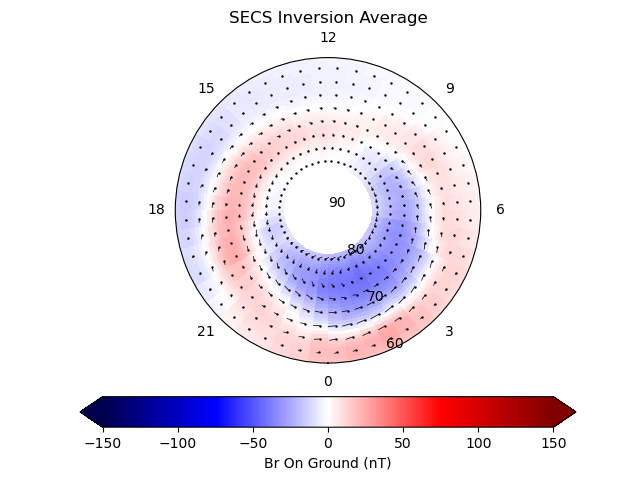

/tmp/ipykernel_178819/2703536824.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 3, 6, 9, 12, 15, 18, 21])


In [6]:
fig= plt.figure()
gs= fig.add_gridspec(2, 1, height_ratios=[1, .1], hspace=0.2)
ax = polar(fig.add_subplot(gs[0], projection='polar'))
cax= fig.add_subplot(gs[1])
ax.ax.set_title('SECS Inversion Average')
cbar=fig.colorbar(mpl.cm.ScalarMappable(norm = mpl.colors.Normalize(vmin=-150, vmax=150), cmap=mpl.cm.seismic), 
                  cax=cax, orientation='horizontal', extend='both')
cbar.set_label(r'Br On Ground (nT)')

## Plotting
Plotting the vectors as pins

In [7]:
# Plotting the start points of the pins, reduced to every 4th mlat point to make the plot easier to interpret
scat=ax.scatter(np.array([mlt_centers]*len(mlat_centers))[::4, :], np.concatenate([np.vstack(mlat_centers[::4])]*len(mlt_centers), axis=1), color='black', s=1/2)
# Plotting the vector represented by the length of the pin, reduced to every 4th mlat point
quiv=ax.quiver(mlt_centers, mlat_centers[::4], East[::4,:], North[::4, :], scale=3, headaxislength=0, headlength=0, zorder=2)

Plotting Br as a pcolormesh

In [8]:
# Using the mlt bin edges and artificial mlat edges that contain one evaluation point to show the radial magnetic field
mesh=ax.pcolormesh(mlt_edges, mlat_edges, Br*1e9, cmap='seismic', vmin=-150, vmax=150, zorder=0)

/tmp/ipykernel_178819/2703536824.py:104: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  return self.old_pcolormesh(*self.conv(mlt, mlat), z, **kwargs)
